### YOLOv11 + fine tuned on DocLayNet dataset (6910 training, 648 validation, 499 test)

Processing with model: yolov11_4_l_tuned.pt

image 1/1 /Users/ayush/Documents/projects/yolov8-inference-optimization/tests/test5.png: 384x640 2 Section-headers, 24 Texts, 142.1ms
Speed: 1.1ms preprocess, 142.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved for model: yolov11_4_l_tuned.pt at output_images/annotated_yolov11_4_l_tuned.jpg
Processing with model: yolov11_5_x_tuned.pt

image 1/1 /Users/ayush/Documents/projects/yolov8-inference-optimization/tests/test5.png: 384x640 2 Section-headers, 24 Texts, 232.9ms
Speed: 1.1ms preprocess, 232.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved for model: yolov11_5_x_tuned.pt at output_images/annotated_yolov11_5_x_tuned.jpg
Processing with model: yolov11_3_m_tuned.pt

image 1/1 /Users/ayush/Documents/projects/yolov8-inference-optimization/tests/test5.png: 384x640 4 Section-headers, 25 Texts, 104.7ms
Speed: 1.0ms preprocess, 104.7ms inference, 0.7ms postprocess per image at sh

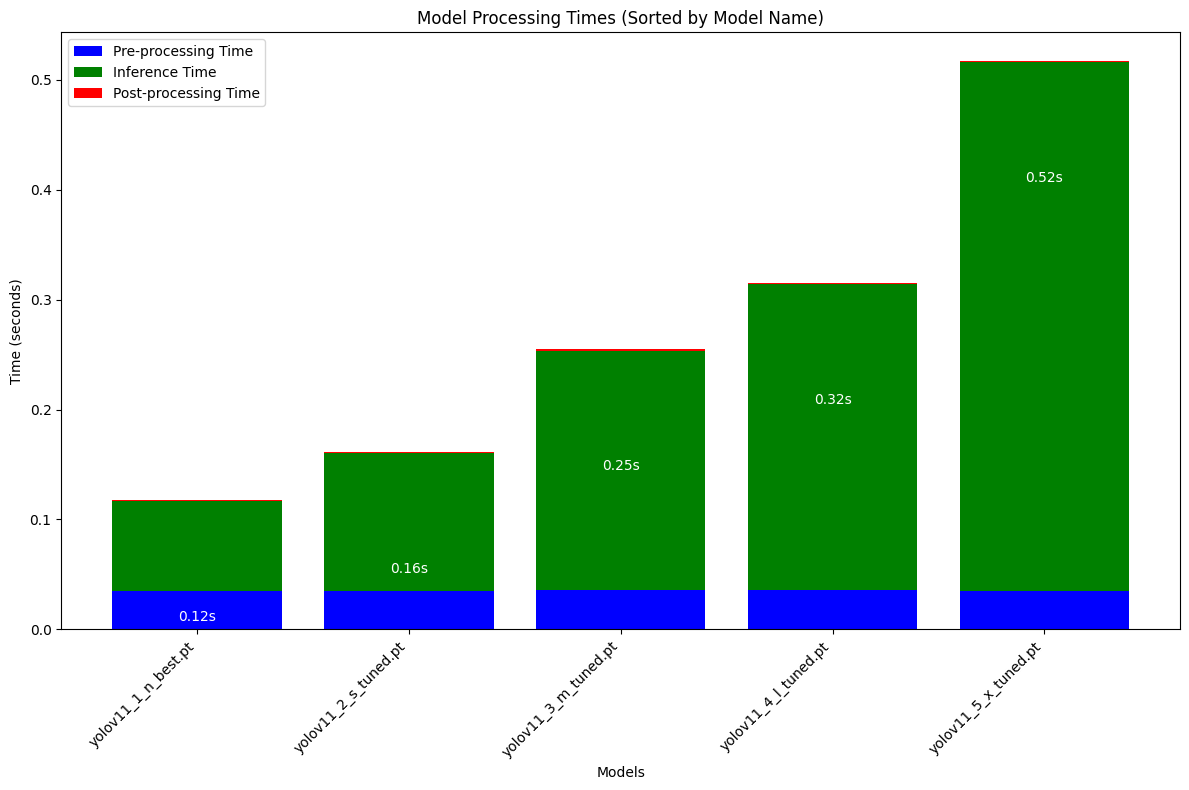

In [10]:
# %%
from ultralytics import YOLO
import supervision as sv
import cv2
import os
import matplotlib.pyplot as plt
import time

# %%
# Folder containing YOLO models
model_folder = "yolo11"
image_path = "./tests/test5.png"
output_folder = "output_images"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Define a custom color palette for each class
class_colors = [
    sv.Color(255, 0, 0),    # Red for "Caption"
    sv.Color(0, 255, 0),    # Green for "Footnote"
    sv.Color(0, 0, 255),    # Blue for "Formula"
    sv.Color(255, 255, 0),  # Yellow for "List-item"
    sv.Color(255, 0, 255),  # Magenta for "Page-footer"
    sv.Color(0, 255, 255),  # Cyan for "Page-header"
    sv.Color(128, 0, 128),  # Purple for "Picture"
    sv.Color(128, 128, 0),  # Olive for "Section-header"
    sv.Color(128, 128, 128),# Gray for "Table"
    sv.Color(0, 128, 128),  # Teal for "Text"
    sv.Color(128, 0, 0)     # Maroon for "Title"
]

# Initialize the BoxAnnotator with the custom color palette and increased thickness
box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette(class_colors),
    thickness=3  # Increased thickness for bounding boxes
)

# Initialize the LabelAnnotator with custom background and text colors
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette(class_colors),  # Background colors matching bounding boxes
    text_color=sv.Color(255, 255, 255)    # White text for better readability
)


model_files = sorted(os.listdir(model_folder), key=lambda f: os.path.getctime(os.path.join(model_folder, f)))
model_files = [f for f in model_files if f.endswith(".pt")]


# Check if there are any models in the folder
if not model_files:
    raise FileNotFoundError("No YOLO model files found in the folder.")

# %%
# Iterate over each model and perform object detection
model_times = []

for model_file in model_files:
    model_path = os.path.join(model_folder, model_file)
    
    print(f"Processing with model: {model_file}")

    # Load the YOLO model
    model = YOLO(model_path)

    # Measure pre-processing time
    start_time = time.time()
    image = cv2.imread(image_path)
    pre_time = time.time() - start_time

    # Perform object detection and measure inference time
    start_time = time.time()
    #results = model(image_path, conf=0.2, iou=0.8, stream=True)[0] (for list of images)
    results = model(image_path, conf=0.2, iou=0.8, stream=False)[0]
    inference_time = time.time() - start_time

    # Measure post-processing time
    start_time = time.time()
    detections = sv.Detections.from_ultralytics(results)
    annotated_image = box_annotator.annotate(
        scene=image,
        detections=detections
    )
    annotated_image = label_annotator.annotate(
        scene=annotated_image,
        detections=detections
    )
    post_time = time.time() - start_time

    # Save the annotated image based on the model name
    output_path = os.path.join(output_folder, f"annotated_{os.path.splitext(model_file)[0]}.jpg")
    cv2.imwrite(output_path, annotated_image)
    
    print(f"Results saved for model: {model_file} at {output_path}")

    # Log times
    total_time = pre_time + inference_time + post_time
    model_times.append({
        "model": model_file,
        "pre_time": pre_time,
        "inference_time": inference_time,
        "post_time": post_time,
        "total_time": total_time
    })


# %%
# Sort model times by model file name in increasing order
model_times = sorted(model_times, key=lambda x: x["model"])

# Extract sorted times
models = [entry["model"] for entry in model_times]
pre_times = [entry["pre_time"] for entry in model_times]
inference_times = [entry["inference_time"] for entry in model_times]
post_times = [entry["post_time"] for entry in model_times]
total_times = [entry["total_time"] for entry in model_times]

x = range(len(models))

# Plotting
plt.figure(figsize=(12, 8))

plt.bar(x, pre_times, label="Pre-processing Time", color="blue")
plt.bar(x, inference_times, bottom=pre_times, label="Inference Time", color="green")
plt.bar(x, post_times, bottom=[i + j for i, j in zip(pre_times, inference_times)], label="Post-processing Time", color="red")

# Annotate total times inside the top section of each bar
for i, total in enumerate(total_times):
    plt.text(
        x=i,
        y=pre_times[i] + inference_times[i] + post_times[i] - 0.1,  # Slightly below the top of the bar
        s=f"{total:.2f}s",
        ha="center",
        va="top",
        fontsize=10,
        color="white"  # White text for visibility against colored bars
    )

plt.xticks(x, models, rotation=45, ha="right")
plt.xlabel("Models")
plt.ylabel("Time (seconds)")
plt.title("Model Processing Times (Sorted by Model Name)")
plt.legend()
plt.tight_layout()

# Save the plot
plot_output_path = os.path.join(output_folder, "model_times_plot.png")
plt.savefig(plot_output_path)


1. Multiple Data Source Compatibility: Whether your data is in the form of individual images, a collection of images, video files, or real-time video streams, predict mode has you covered.
2. Streaming Mode: Use the streaming feature to generate a memory-efficient generator of Results objects. Enable this by setting stream=True in the predictor's call method.
3. Batch Processing: The ability to process multiple images or video frames in a single batch, further speeding up inference time.

Processing with model: yolo11/yolov11_4_l_tuned.ptProcessing with model: yolo11/yolov11_5_x_tuned.pt

Processing with model: yolo11/yolov11_3_m_tuned.pt
Processing with model: yolo11/yolov11_2_s_tuned.pt
Processing with model: yolo11/yolov11_1_n_best.pt


image 1/1 /Users/ayush/Documents/projects/yolov8-inference-optimization/tests/test5.png: 384x640 2 Page-footers, 2 Section-headers, 20 Texts, 64.9ms
Speed: 3.1ms preprocess, 64.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved for model: yolo11/yolov11_1_n_best.pt at output_images/annotated_yolo11/yolov11_1_n_best.jpg
Model: yolo11/yolov11_1_n_best.pt, Pre-processing: 0.05s, Inference: 0.28s, Post-processing: 0.00s, Total: 0.33s

image 1/1 /Users/ayush/Documents/projects/yolov8-inference-optimization/tests/test5.png: 384x640 3 Section-headers, 24 Texts, 96.9ms
Speed: 1.3ms preprocess, 96.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved for model: yolo11/yolov11_2_s_tun

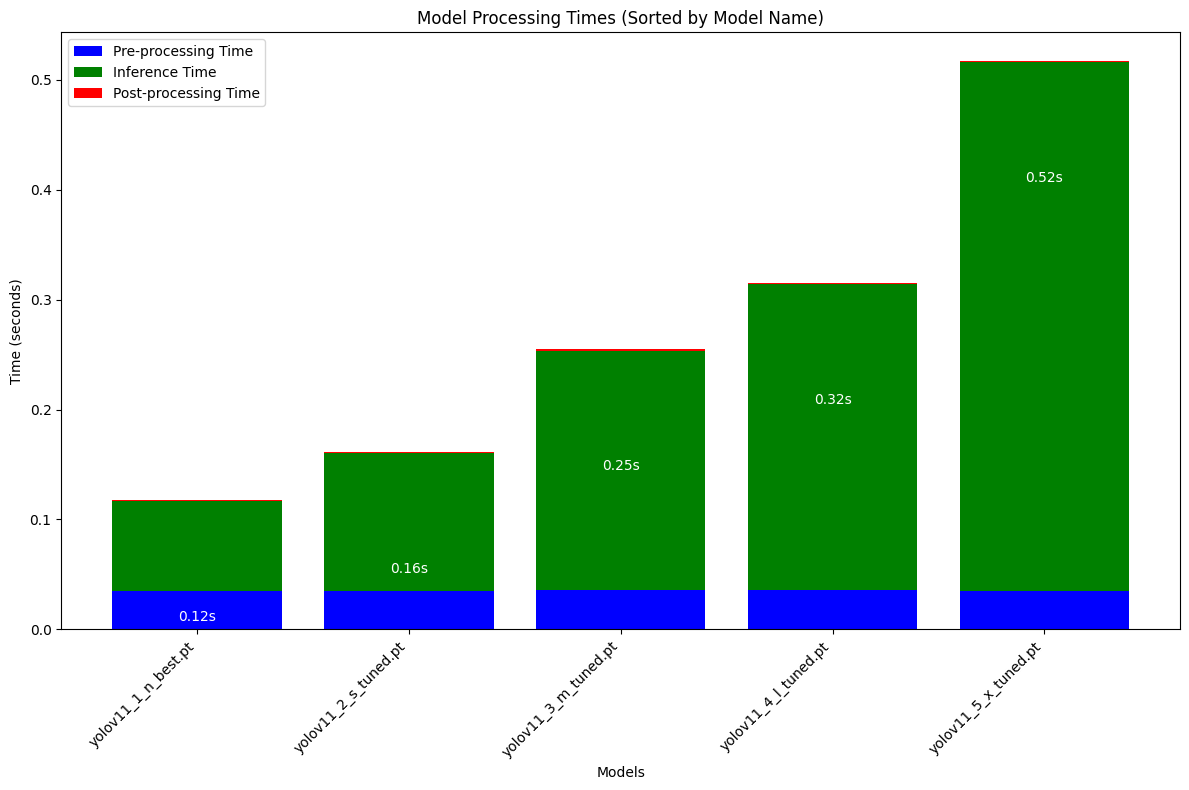

In [11]:
# %%
from ultralytics import YOLO
import supervision as sv
import cv2
import os
import matplotlib.pyplot as plt
import time
from threading import Thread

# %%
# Folder containing YOLO models
model_folder = "yolo11"
image_path = "tests/test5.png"
output_folder = "output_images"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Define a custom color palette for each class
class_colors = [
    sv.Color(255, 0, 0),    # Red for "Caption"
    sv.Color(0, 255, 0),    # Green for "Footnote"
    sv.Color(0, 0, 255),    # Blue for "Formula"
    sv.Color(255, 255, 0),  # Yellow for "List-item"
    sv.Color(255, 0, 255),  # Magenta for "Page-footer"
    sv.Color(0, 255, 255),  # Cyan for "Page-header"
    sv.Color(128, 0, 128),  # Purple for "Picture"
    sv.Color(128, 128, 0),  # Olive for "Section-header"
    sv.Color(128, 128, 128),# Gray for "Table"
    sv.Color(0, 128, 128),  # Teal for "Text"
    sv.Color(128, 0, 0)     # Maroon for "Title"
]

# Initialize the BoxAnnotator with the custom color palette and increased thickness
box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette(class_colors),
    thickness=3  # Increased thickness for bounding boxes
)

# Initialize the LabelAnnotator with custom background and text colors
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette(class_colors),  # Background colors matching bounding boxes
    text_color=sv.Color(255, 255, 255)    # White text for better readability
)


model_files = sorted(os.listdir(model_folder), key=lambda f: os.path.getctime(os.path.join(model_folder, f)))
model_files = [f for f in model_files if f.endswith(".pt")]

# Check if there are any models in the folder
if not model_files:
    raise FileNotFoundError("No YOLO model files found in the folder.")

# %%
# Thread-safe prediction function
def thread_safe_predict(model_file, image_path, output_folder):
    """Thread-safe inference using YOLO model."""
    print(f"Processing with model: {model_file}")
    
    model = YOLO(model_file)
    
    # Measure pre-processing time
    start_time = time.time()
    image = cv2.imread(image_path)
    pre_time = time.time() - start_time

    # Perform object detection and measure inference time
    start_time = time.time()
    results = model(image_path, conf=0.2, iou=0.8, stream=False)[0]
    inference_time = time.time() - start_time

    # Measure post-processing time
    start_time = time.time()
    detections = sv.Detections.from_ultralytics(results)
    annotated_image = box_annotator.annotate(
        scene=image,
        detections=detections
    )
    annotated_image = label_annotator.annotate(
        scene=annotated_image,
        detections=detections
    )
    post_time = time.time() - start_time

    # Save the annotated image based on the model name
    output_path = os.path.join(output_folder, f"annotated_{os.path.splitext(model_file)[0]}.jpg")
    cv2.imwrite(output_path, annotated_image)
    print(f"Results saved for model: {model_file} at {output_path}")

    # Log processing times
    total_time = pre_time + inference_time + post_time
    print(f"Model: {model_file}, Pre-processing: {pre_time:.2f}s, "
          f"Inference: {inference_time:.2f}s, Post-processing: {post_time:.2f}s, Total: {total_time:.2f}s")

# %%
# Start threads for each model
threads = []
for model_file in model_files:
    model_path = os.path.join(model_folder, model_file)
    thread = Thread(target=thread_safe_predict, args=(model_path, image_path, output_folder))
    threads.append(thread)
    thread.start()

# Wait for all threads to complete
for thread in threads:
    thread.join()

# %%%%%%%%%
# Plot times for each model (Manually compile times if needed)

# %%
# Sort model times by model file name in increasing order
model_times = sorted(model_times, key=lambda x: x["model"])

# Extract sorted times
models = [entry["model"] for entry in model_times]
pre_times = [entry["pre_time"] for entry in model_times]
inference_times = [entry["inference_time"] for entry in model_times]
post_times = [entry["post_time"] for entry in model_times]
total_times = [entry["total_time"] for entry in model_times]

x = range(len(models))

# Plotting
plt.figure(figsize=(12, 8))

plt.bar(x, pre_times, label="Pre-processing Time", color="blue")
plt.bar(x, inference_times, bottom=pre_times, label="Inference Time", color="green")
plt.bar(x, post_times, bottom=[i + j for i, j in zip(pre_times, inference_times)], label="Post-processing Time", color="red")

# Annotate total times inside the top section of each bar
for i, total in enumerate(total_times):
    plt.text(
        x=i,
        y=pre_times[i] + inference_times[i] + post_times[i] - 0.1,  # Slightly below the top of the bar
        s=f"{total:.2f}s",
        ha="center",
        va="top",
        fontsize=10,
        color="white"  # White text for visibility against colored bars
    )

plt.xticks(x, models, rotation=45, ha="right")
plt.xlabel("Models")
plt.ylabel("Time (seconds)")
plt.title("Model Processing Times (Sorted by Model Name)")
plt.legend()
plt.tight_layout()

# Save the plot
plot_output_path = os.path.join(output_folder, "model_times_plot.png")
plt.savefig(plot_output_path)
